In [ ]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [ ]:
create_experiment_snapshots([25, 50, 75, 100])

In [ ]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = [100]
network_size = [25]
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 10

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.normalization_values = self.get_scheme_values('nomtd')




    def get_scheme_values(self, scheme):
        # Simulate and stack nomtd DataFrames
        dfs = []
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = pd.DataFrame(single_mtd_simulation("no_mtd", [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)), mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
            elif scheme == 'mtd_ai':
                mtd = pd.DataFrame(mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, mtd_interval=self.mtd_interval,network_size=self.network_size )).drop('Name', axis=1)
            else:
                mtd = pd.DataFrame(specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
                
            dfs.append(mtd)
        stacked_nomtd = pd.concat(dfs, ignore_index=True)
        # Calculate median for normalization
        median_df = stacked_nomtd.groupby(['mtd_interval', 'network_size']).median().loc[self.mtd_interval[0],self.network_size[0]].to_dict()

        

        return median_df

    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {'ASR', 'ROA', 'exposed_endpoints'}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure'}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics


    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()




In [ ]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial)

In [ ]:
radar.normalization_values

In [68]:

labels = ['MEF', 'ASR', 'time_to_compromise', 'host_compromise_ratio', 'exposed_endpoints', 'attack_path_exposure', 'ROA', 'risk', 'shortest_path_variability']
results = {}
actual_results = {}
for scheme in radar.schemes:
    scheme_result = radar.get_scheme_values(scheme)
    scaled_metrics = radar.scale_metrics(scheme_result,radar.normalization_values)
    results[scheme] = scaled_metrics
    actual_results[scheme] = scheme_result


MTD: Interrupted EXPLOIT_VULN at 3026.4s!
MTD: CompleteTopologyShuffle triggered 3116.7s
MTD: ServiceDiversity triggered 3219.6s
MTD: Interrupted ENUM_HOST at 3237.1s!
MTD: IPShuffle triggered 3319.7s
MTD: ServiceDiversity triggered 3420.1s
MTD: Interrupted SCAN_NEIGHBOR at 3430.4s!
MTD: ServiceDiversity triggered 3520.1s
MTD: ServiceDiversity triggered 3620.3s
MTD: CompleteTopologyShuffle triggered 3720.4s
MTD: IPShuffle triggered 3821.3s
MTD: Interrupted EXPLOIT_VULN at 3840.5s!
MTD: IPShuffle triggered 3921.6s
MTD: ServiceDiversity triggered 4023.3s
MTD: Interrupted SCAN_PORT at 4031.7s!


random


MTD: ServiceDiversity triggered 4123.8s
MTD: OSDiversity triggered 4224.2s
MTD: OSDiversity triggered 4324.4s
MTD: IPShuffle triggered 4424.6s
MTD: IPShuffle triggered 4524.9s
MTD: Interrupted EXPLOIT_VULN at 4534.6s!
MTD: IPShuffle triggered 4625.1s
MTD: OSDiversity triggered 4725.4s
MTD: Interrupted EXPLOIT_VULN at 4735.5s!
MTD: ServiceDiversity triggered 4825.5s
MTD: CompleteTopologyShuffle triggered 4925.7s
MTD: ServiceDiversity triggered 5025.8s
MTD: Interrupted ENUM_HOST at 5047.4s!
MTD: OSDiversity triggered 5126.8s
MTD: IPShuffle triggered 5228.2s
MTD: CompleteTopologyShuffle triggered 5330.3s
MTD: Interrupted SCAN_NEIGHBOR at 5338.5s!
MTD: CompleteTopologyShuffle triggered 5430.8s
MTD: IPShuffle triggered 5531.0s
MTD: Interrupted SCAN_PORT at 5550.8s!
MTD: IPShuffle triggered 5631.2s
MTD: OSDiversity triggered 5731.3s
MTD: Interrupted EXPLOIT_VULN at 5741.6s!
MTD: IPShuffle triggered 5832.1s
MTD: OSDiversity triggered 5932.1s
MTD: Interrupted EXPLOIT_VULN at 5943.2s!
MTD: IPSh

random


MTD: CompleteTopologyShuffle triggered 4528.6s
MTD: Interrupted ENUM_HOST at 4537.6s!
MTD: CompleteTopologyShuffle triggered 4628.8s
MTD: ServiceDiversity triggered 4729.5s
MTD: Interrupted ENUM_HOST at 4749.1s!
MTD: IPShuffle triggered 4829.6s
MTD: IPShuffle triggered 4929.7s
MTD: Interrupted ENUM_HOST at 4939.8s!
MTD: IPShuffle triggered 5029.9s
MTD: IPShuffle triggered 5131.0s
MTD: Interrupted ENUM_HOST at 5140.0s!
MTD: IPShuffle triggered 5231.5s
MTD: OSDiversity triggered 5332.0s
MTD: Interrupted EXPLOIT_VULN at 5342.9s!
MTD: IPShuffle triggered 5432.2s
MTD: ServiceDiversity triggered 5532.3s
MTD: Interrupted EXPLOIT_VULN at 5542.7s!
MTD: IPShuffle triggered 5632.7s
MTD: OSDiversity triggered 5733.9s
MTD: Interrupted EXPLOIT_VULN at 5743.6s!
MTD: ServiceDiversity triggered 5834.1s
MTD: OSDiversity triggered 5934.8s
MTD: OSDiversity triggered 6035.1s
MTD: ServiceDiversity triggered 6136.2s
MTD: OSDiversity triggered 6237.3s
MTD: CompleteTopologyShuffle triggered 6337.5s


random


MTD: OSDiversity triggered 0.0s
MTD: IPShuffle triggered 100.2s
MTD: IPShuffle triggered 200.4s
MTD: Interrupted EXPLOIT_VULN at 210.2s!
MTD: IPShuffle triggered 300.8s
MTD: ServiceDiversity triggered 400.9s
MTD: Interrupted EXPLOIT_VULN at 412.4s!
MTD: CompleteTopologyShuffle triggered 500.9s
MTD: CompleteTopologyShuffle triggered 601.5s
MTD: Interrupted EXPLOIT_VULN at 621.6s!
MTD: CompleteTopologyShuffle triggered 703.8s
MTD: IPShuffle triggered 804.1s
MTD: Interrupted SCAN_NEIGHBOR at 824.1s!
MTD: IPShuffle triggered 904.4s
MTD: IPShuffle triggered 1005.0s
MTD: Interrupted SCAN_PORT at 1014.7s!
MTD: IPShuffle triggered 1105.2s
MTD: ServiceDiversity triggered 1205.5s
MTD: Interrupted EXPLOIT_VULN at 1217.2s!
MTD: OSDiversity triggered 1305.7s
MTD: OSDiversity triggered 1405.8s
MTD: IPShuffle triggered 1506.1s
MTD: IPShuffle triggered 1606.2s
MTD: Interrupted EXPLOIT_VULN at 1616.3s!
MTD: IPShuffle triggered 1706.3s
MTD: IPShuffle triggered 1806.6s
MTD: Interrupted EXPLOIT_VULN at 18

random


MTD: CompleteTopologyShuffle triggered 4017.3s
MTD: Interrupted EXPLOIT_VULN at 4027.3s!
MTD: CompleteTopologyShuffle triggered 4117.7s
MTD: ServiceDiversity triggered 4217.8s
MTD: Interrupted EXPLOIT_VULN at 4237.9s!
MTD: ServiceDiversity triggered 4317.8s
MTD: ServiceDiversity triggered 4419.2s
MTD: IPShuffle triggered 4519.2s
MTD: CompleteTopologyShuffle triggered 4619.7s
MTD: Interrupted EXPLOIT_VULN at 4629.2s!
MTD: CompleteTopologyShuffle triggered 4720.3s
MTD: ServiceDiversity triggered 4821.1s
MTD: Interrupted EXPLOIT_VULN at 4840.4s!
MTD: IPShuffle triggered 4921.7s
MTD: IPShuffle triggered 5022.3s
MTD: Interrupted EXPLOIT_VULN at 5032.8s!
MTD: IPShuffle triggered 5122.7s
MTD: CompleteTopologyShuffle triggered 5223.2s
MTD: Interrupted SCAN_PORT at 5232.9s!
MTD: CompleteTopologyShuffle triggered 5324.0s
MTD: IPShuffle triggered 5424.4s
MTD: Interrupted EXPLOIT_VULN at 5444.2s!
MTD: IPShuffle triggered 5525.4s
MTD: IPShuffle triggered 5625.6s
MTD: Interrupted EXPLOIT_VULN at 563

random


MTD: ServiceDiversity triggered 4523.1s
MTD: Interrupted EXPLOIT_VULN at 4532.8s!
MTD: ServiceDiversity triggered 4623.4s
MTD: OSDiversity triggered 4723.6s
MTD: ServiceDiversity triggered 4823.8s
MTD: ServiceDiversity triggered 4924.9s
MTD: IPShuffle triggered 5025.2s
MTD: CompleteTopologyShuffle triggered 5125.6s
MTD: Interrupted SCAN_NEIGHBOR at 5135.2s!
MTD: CompleteTopologyShuffle triggered 5225.9s
MTD: OSDiversity triggered 5326.3s
MTD: Interrupted EXPLOIT_VULN at 5346.2s!
MTD: IPShuffle triggered 5426.9s
MTD: IPShuffle triggered 5527.7s
MTD: Interrupted EXPLOIT_VULN at 5536.9s!
MTD: IPShuffle triggered 5629.4s
MTD: IPShuffle triggered 5729.5s
MTD: Interrupted EXPLOIT_VULN at 5741.0s!
MTD: IPShuffle triggered 5830.4s
MTD: ServiceDiversity triggered 5930.5s
MTD: Interrupted SCAN_PORT at 5940.5s!
MTD: OSDiversity triggered 6030.9s
MTD: IPShuffle triggered 6131.4s
MTD: IPShuffle triggered 6231.9s
MTD: Interrupted ENUM_HOST at 6241.5s!
MTD: IPShuffle triggered 6332.4s
MTD: IPShuffle 

random


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: ServiceDiversity triggered 100.7s
MTD: Interrupted EXPLOIT_VULN at 120.0s!
MTD: OSDiversity triggered 201.1s
MTD: OSDiversity triggered 301.3s
MTD: ServiceDiversity triggered 401.3s
MTD: IPShuffle triggered 501.4s
MTD: OSDiversity triggered 601.8s
MTD: Interrupted EXPLOIT_VULN at 611.4s!
MTD: CompleteTopologyShuffle triggered 703.5s
MTD: ServiceDiversity triggered 804.0s
MTD: Interrupted EXPLOIT_VULN at 823.5s!
MTD: IPShuffle triggered 905.1s
MTD: OSDiversity triggered 1005.1s
MTD: Interrupted SCAN_PORT at 1016.2s!
MTD: OSDiversity triggered 1106.7s
MTD: IPShuffle triggered 1208.0s
MTD: CompleteTopologyShuffle triggered 1308.2s
MTD: Interrupted EXPLOIT_VULN at 1318.3s!
MTD: CompleteTopologyShuffle triggered 1411.0s
MTD: OSDiversity triggered 1511.0s
MTD: Interrupted EXPLOIT_VULN at 1531.6s!
MTD: ServiceDiversity triggered 1611.0s
MTD: OSDiversity triggered 1711.1s
MTD: ServiceDiversity triggered 1812.2s
MTD: OSDiversity triggered 1913.0s

random


MTD: Interrupted EXPLOIT_VULN at 4343.6s!
MTD: IPShuffle triggered 4424.2s
MTD: CompleteTopologyShuffle triggered 4524.9s
MTD: Interrupted SCAN_NEIGHBOR at 4534.4s!
MTD: CompleteTopologyShuffle triggered 4625.5s
MTD: ServiceDiversity triggered 4726.8s
MTD: Interrupted EXPLOIT_VULN at 4746.1s!
MTD: CompleteTopologyShuffle triggered 4828.0s
MTD: IPShuffle triggered 4928.1s
MTD: Interrupted EXPLOIT_VULN at 4948.1s!
MTD: IPShuffle triggered 5028.4s
MTD: IPShuffle triggered 5128.4s
MTD: Interrupted EXPLOIT_VULN at 5139.2s!
MTD: IPShuffle triggered 5229.4s
MTD: ServiceDiversity triggered 5333.2s
MTD: Interrupted ENUM_HOST at 5339.4s!
MTD: OSDiversity triggered 5433.4s
MTD: OSDiversity triggered 5533.8s
MTD: ServiceDiversity triggered 5634.0s
MTD: ServiceDiversity triggered 5734.7s
MTD: OSDiversity triggered 5835.8s
MTD: ServiceDiversity triggered 5936.1s
MTD: CompleteTopologyShuffle triggered 6036.6s
MTD: CompleteTopologyShuffle triggered 6136.7s
MTD: Interrupted SCAN_NEIGHBOR at 6156.7s!
MT

random


MTD: Interrupted EXPLOIT_VULN at 4239.6s!
MTD: CompleteTopologyShuffle triggered 4320.4s
MTD: ServiceDiversity triggered 4420.8s
MTD: Interrupted EXPLOIT_VULN at 4440.7s!
MTD: ServiceDiversity triggered 4521.9s
MTD: CompleteTopologyShuffle triggered 4622.6s
MTD: CompleteTopologyShuffle triggered 4722.6s
MTD: Interrupted EXPLOIT_VULN at 4742.6s!
MTD: CompleteTopologyShuffle triggered 4823.1s
MTD: CompleteTopologyShuffle triggered 4923.2s
MTD: Interrupted EXPLOIT_VULN at 4944.1s!
MTD: CompleteTopologyShuffle triggered 5024.6s
MTD: IPShuffle triggered 5125.7s
MTD: Interrupted SCAN_PORT at 5145.0s!
MTD: IPShuffle triggered 5226.5s
MTD: OSDiversity triggered 5327.5s
MTD: Interrupted EXPLOIT_VULN at 5336.5s!
MTD: OSDiversity triggered 5427.7s
MTD: OSDiversity triggered 5529.6s
MTD: IPShuffle triggered 5629.9s
MTD: OSDiversity triggered 5730.3s
MTD: Interrupted EXPLOIT_VULN at 5741.0s!
MTD: CompleteTopologyShuffle triggered 5830.9s
MTD: IPShuffle triggered 5931.2s
MTD: Interrupted SCAN_PORT a

random


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: ServiceDiversity triggered 100.2s
MTD: Interrupted EXPLOIT_VULN at 120.1s!
MTD: OSDiversity triggered 201.6s
MTD: ServiceDiversity triggered 302.0s
MTD: OSDiversity triggered 402.5s
MTD: ServiceDiversity triggered 502.9s
MTD: IPShuffle triggered 602.9s
MTD: CompleteTopologyShuffle triggered 703.6s
MTD: Interrupted EXPLOIT_VULN at 713.0s!
MTD: CompleteTopologyShuffle triggered 803.7s
MTD: OSDiversity triggered 904.2s
MTD: Interrupted SCAN_PORT at 924.1s!
MTD: IPShuffle triggered 1004.6s
MTD: IPShuffle triggered 1104.8s
MTD: Interrupted EXPLOIT_VULN at 1115.3s!
MTD: IPShuffle triggered 1205.0s
MTD: IPShuffle triggered 1305.0s
MTD: Interrupted EXPLOIT_VULN at 1315.2s!
MTD: IPShuffle triggered 1405.3s
MTD: OSDiversity triggered 1505.5s
MTD: Interrupted EXPLOIT_VULN at 1515.6s!
MTD: IPShuffle triggered 1608.7s
MTD: CompleteTopologyShuffle triggered 1708.9s
MTD: Interrupted ENUM_HOST at 1719.2s!
MTD: CompleteTopologyShuffle triggered 1809.1s
M

random


MTD: CompleteTopologyShuffle triggered 4521.5s
MTD: IPShuffle triggered 4622.0s
MTD: Interrupted ENUM_HOST at 4642.1s!
MTD: IPShuffle triggered 4722.2s
MTD: OSDiversity triggered 4824.0s
MTD: Interrupted ENUM_HOST at 4833.4s!
MTD: ServiceDiversity triggered 4924.3s
MTD: CompleteTopologyShuffle triggered 5024.6s
MTD: IPShuffle triggered 5126.6s
MTD: Interrupted BRUTE_FORCE at 5145.4s!
MTD: IPShuffle triggered 5226.6s
MTD: OSDiversity triggered 5326.9s
MTD: Interrupted EXPLOIT_VULN at 5336.8s!
MTD: ServiceDiversity triggered 5426.9s
MTD: CompleteTopologyShuffle triggered 5527.5s
MTD: IPShuffle triggered 5627.7s
MTD: Interrupted EXPLOIT_VULN at 5648.3s!
MTD: IPShuffle triggered 5728.0s
MTD: OSDiversity triggered 5829.2s
MTD: Interrupted EXPLOIT_VULN at 5838.8s!
MTD: ServiceDiversity triggered 5929.6s
MTD: CompleteTopologyShuffle triggered 6029.8s
MTD: IPShuffle triggered 6130.5s
MTD: Interrupted SCAN_PORT at 6149.9s!
MTD: IPShuffle triggered 6230.6s
MTD: OSDiversity triggered 6330.6s
MTD:

alternative


MTD: ServiceDiversity triggered 4429.6s
MTD: CompleteTopologyShuffle triggered 4530.0s
MTD: IPShuffle triggered 4630.2s
MTD: Interrupted EXPLOIT_VULN at 4650.2s!
MTD: IPShuffle triggered 4731.1s
MTD: OSDiversity triggered 4832.2s
MTD: Interrupted SCAN_PORT at 4841.1s!
MTD: ServiceDiversity triggered 4933.9s
MTD: CompleteTopologyShuffle triggered 5035.1s
MTD: IPShuffle triggered 5135.1s
MTD: Interrupted EXPLOIT_VULN at 5155.2s!
MTD: IPShuffle triggered 5235.4s
MTD: OSDiversity triggered 5335.4s
MTD: Interrupted EXPLOIT_VULN at 5345.6s!
MTD: ServiceDiversity triggered 5436.6s
MTD: CompleteTopologyShuffle triggered 5537.5s
MTD: IPShuffle triggered 5637.5s
MTD: Interrupted EXPLOIT_VULN at 5659.2s!
MTD: IPShuffle triggered 5738.0s
MTD: OSDiversity triggered 5838.6s
MTD: Interrupted ENUM_HOST at 5848.0s!
MTD: ServiceDiversity triggered 5938.7s
MTD: CompleteTopologyShuffle triggered 6039.2s
MTD: IPShuffle triggered 6139.6s
MTD: Interrupted EXPLOIT_VULN at 6159.7s!
MTD: IPShuffle triggered 623

alternative


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 100.0s
MTD: Interrupted EXPLOIT_VULN at 120.3s!
MTD: IPShuffle triggered 200.7s
MTD: OSDiversity triggered 301.6s
MTD: Interrupted EXPLOIT_VULN at 310.8s!
MTD: ServiceDiversity triggered 402.5s
MTD: CompleteTopologyShuffle triggered 502.8s
MTD: IPShuffle triggered 604.4s
MTD: Interrupted EXPLOIT_VULN at 623.5s!
MTD: IPShuffle triggered 704.4s
MTD: OSDiversity triggered 804.9s
MTD: Interrupted SCAN_PORT at 814.7s!
MTD: ServiceDiversity triggered 905.0s
MTD: CompleteTopologyShuffle triggered 1006.7s
MTD: IPShuffle triggered 1107.2s
MTD: Interrupted EXPLOIT_VULN at 1127.6s!
MTD: IPShuffle triggered 1207.6s
MTD: OSDiversity triggered 1308.9s
MTD: Interrupted EXPLOIT_VULN at 1317.7s!
MTD: ServiceDiversity triggered 1410.0s
MTD: CompleteTopologyShuffle triggered 1510.1s
MTD: IPShuffle triggered 1610.7s
MTD: Interrupted SCAN_NEIGHBOR at 1631.0s!
MTD: IPShuffle triggered 1711.6s
MTD: OSDiversity triggered 1811.7s
MTD: Interru

alternative


MTD: OSDiversity triggered 4322.2s
MTD: Interrupted EXPLOIT_VULN at 4332.7s!
MTD: ServiceDiversity triggered 4422.9s
MTD: CompleteTopologyShuffle triggered 4523.0s
MTD: IPShuffle triggered 4623.1s
MTD: Interrupted EXPLOIT_VULN at 4643.4s!
MTD: IPShuffle triggered 4723.6s
MTD: OSDiversity triggered 4824.7s
MTD: Interrupted ENUM_HOST at 4834.5s!
MTD: ServiceDiversity triggered 4925.5s
MTD: CompleteTopologyShuffle triggered 5025.9s
MTD: IPShuffle triggered 5127.0s
MTD: Interrupted EXPLOIT_VULN at 5146.5s!
MTD: IPShuffle triggered 5227.9s
MTD: OSDiversity triggered 5328.7s
MTD: Interrupted EXPLOIT_VULN at 5338.2s!
MTD: ServiceDiversity triggered 5429.0s
MTD: CompleteTopologyShuffle triggered 5529.3s
MTD: IPShuffle triggered 5629.6s
MTD: Interrupted SCAN_PORT at 5649.7s!
MTD: IPShuffle triggered 5731.7s
MTD: OSDiversity triggered 5832.5s
MTD: Interrupted EXPLOIT_VULN at 5841.8s!
MTD: ServiceDiversity triggered 5933.7s
MTD: CompleteTopologyShuffle triggered 6034.1s
MTD: IPShuffle triggered 6

alternative


MTD: Interrupted EXPLOIT_VULN at 3132.6s!
MTD: IPShuffle triggered 3214.5s
MTD: OSDiversity triggered 3314.7s
MTD: Interrupted EXPLOIT_VULN at 3326.2s!
MTD: ServiceDiversity triggered 3415.0s
MTD: CompleteTopologyShuffle triggered 3515.7s
MTD: IPShuffle triggered 3616.3s
MTD: Interrupted EXPLOIT_VULN at 3635.8s!
MTD: IPShuffle triggered 3718.2s
MTD: OSDiversity triggered 3819.0s
MTD: Interrupted EXPLOIT_VULN at 3829.1s!
MTD: ServiceDiversity triggered 3920.8s
MTD: CompleteTopologyShuffle triggered 4021.0s
MTD: IPShuffle triggered 4121.4s
MTD: Interrupted EXPLOIT_VULN at 4141.6s!
MTD: IPShuffle triggered 4222.0s
MTD: OSDiversity triggered 4322.4s
MTD: Interrupted EXPLOIT_VULN at 4332.7s!
MTD: ServiceDiversity triggered 4422.6s
MTD: CompleteTopologyShuffle triggered 4523.0s
MTD: IPShuffle triggered 4623.6s
MTD: Interrupted EXPLOIT_VULN at 4644.6s!
MTD: IPShuffle triggered 4723.8s
MTD: OSDiversity triggered 4825.0s
MTD: Interrupted ENUM_HOST at 4835.2s!
MTD: ServiceDiversity triggered 492

alternative


MTD: ServiceDiversity triggered 4422.9s
MTD: CompleteTopologyShuffle triggered 4522.9s
MTD: IPShuffle triggered 4624.5s
MTD: Interrupted SCAN_PORT at 4643.3s!
MTD: IPShuffle triggered 4725.5s
MTD: OSDiversity triggered 4825.5s
MTD: Interrupted SCAN_PORT at 4835.6s!
MTD: ServiceDiversity triggered 4926.5s
MTD: CompleteTopologyShuffle triggered 5027.3s
MTD: IPShuffle triggered 5128.2s
MTD: Interrupted ENUM_HOST at 5147.6s!
MTD: IPShuffle triggered 5228.9s
MTD: OSDiversity triggered 5329.0s
MTD: Interrupted SCAN_NEIGHBOR at 5339.5s!
MTD: ServiceDiversity triggered 5430.3s
MTD: CompleteTopologyShuffle triggered 5531.1s
MTD: IPShuffle triggered 5631.5s
MTD: Interrupted EXPLOIT_VULN at 5651.9s!
MTD: IPShuffle triggered 5731.8s
MTD: OSDiversity triggered 5832.1s
MTD: Interrupted ENUM_HOST at 5842.8s!
MTD: ServiceDiversity triggered 5932.1s
MTD: CompleteTopologyShuffle triggered 6032.2s
MTD: IPShuffle triggered 6132.7s
MTD: Interrupted EXPLOIT_VULN at 6152.3s!
MTD: IPShuffle triggered 6233.8s


alternative


MTD: Interrupted EXPLOIT_VULN at 4143.9s!
MTD: IPShuffle triggered 4224.8s
MTD: OSDiversity triggered 4325.3s
MTD: Interrupted EXPLOIT_VULN at 4335.3s!
MTD: ServiceDiversity triggered 4425.4s
MTD: CompleteTopologyShuffle triggered 4526.2s
MTD: IPShuffle triggered 4626.4s
MTD: Interrupted EXPLOIT_VULN at 4647.2s!
MTD: IPShuffle triggered 4727.3s
MTD: OSDiversity triggered 4827.5s
MTD: Interrupted ENUM_HOST at 4839.0s!
MTD: ServiceDiversity triggered 4928.4s
MTD: CompleteTopologyShuffle triggered 5028.9s
MTD: IPShuffle triggered 5129.2s
MTD: Interrupted EXPLOIT_VULN at 5149.1s!
MTD: IPShuffle triggered 5229.2s
MTD: OSDiversity triggered 5329.7s
MTD: Interrupted EXPLOIT_VULN at 5339.3s!
MTD: ServiceDiversity triggered 5430.2s
MTD: CompleteTopologyShuffle triggered 5530.6s
MTD: IPShuffle triggered 5632.6s
MTD: Interrupted EXPLOIT_VULN at 5651.3s!
MTD: IPShuffle triggered 5734.1s
MTD: OSDiversity triggered 5834.3s
MTD: Interrupted SCAN_PORT at 5844.2s!
MTD: ServiceDiversity triggered 5934.7

alternative


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 100.7s
MTD: Interrupted EXPLOIT_VULN at 120.9s!
MTD: IPShuffle triggered 201.4s
MTD: OSDiversity triggered 301.4s
MTD: Interrupted EXPLOIT_VULN at 312.2s!
MTD: ServiceDiversity triggered 401.9s
MTD: CompleteTopologyShuffle triggered 502.0s
MTD: IPShuffle triggered 602.0s
MTD: Interrupted EXPLOIT_VULN at 622.0s!
MTD: IPShuffle triggered 702.3s
MTD: OSDiversity triggered 802.9s
MTD: Interrupted SCAN_PORT at 813.1s!
MTD: ServiceDiversity triggered 903.6s
MTD: CompleteTopologyShuffle triggered 1005.4s
MTD: IPShuffle triggered 1106.0s
MTD: Interrupted EXPLOIT_VULN at 1125.7s!
MTD: IPShuffle triggered 1206.1s
MTD: OSDiversity triggered 1306.1s
MTD: Interrupted EXPLOIT_VULN at 1316.1s!
MTD: ServiceDiversity triggered 1406.5s
MTD: CompleteTopologyShuffle triggered 1506.7s
MTD: IPShuffle triggered 1606.8s
MTD: Interrupted EXPLOIT_VULN at 1627.1s!
MTD: IPShuffle triggered 1707.0s
MTD: OSDiversity triggered 1807.1s
MTD: Interrup

alternative


MTD: OSDiversity triggered 4322.1s
MTD: Interrupted EXPLOIT_VULN at 4332.3s!
MTD: ServiceDiversity triggered 4422.7s
MTD: CompleteTopologyShuffle triggered 4522.8s
MTD: IPShuffle triggered 4623.6s
MTD: Interrupted EXPLOIT_VULN at 4643.8s!
MTD: IPShuffle triggered 4723.8s
MTD: OSDiversity triggered 4823.9s
MTD: Interrupted EXPLOIT_VULN at 4834.2s!
MTD: ServiceDiversity triggered 4924.2s
MTD: CompleteTopologyShuffle triggered 5024.4s
MTD: IPShuffle triggered 5124.5s
MTD: Interrupted ENUM_HOST at 5145.1s!
MTD: IPShuffle triggered 5225.1s
MTD: OSDiversity triggered 5325.9s
MTD: Interrupted EXPLOIT_VULN at 5335.6s!
MTD: ServiceDiversity triggered 5427.8s
MTD: CompleteTopologyShuffle triggered 5527.9s
MTD: IPShuffle triggered 5628.3s
MTD: Interrupted ENUM_HOST at 5648.4s!
MTD: IPShuffle triggered 5729.7s
MTD: OSDiversity triggered 5829.9s
MTD: Interrupted EXPLOIT_VULN at 5840.4s!
MTD: ServiceDiversity triggered 5930.9s
MTD: CompleteTopologyShuffle triggered 6031.4s
MTD: IPShuffle triggered 6

alternative


MTD: CompleteTopologyShuffle triggered 4016.9s
MTD: IPShuffle triggered 4117.2s
MTD: Interrupted EXPLOIT_VULN at 4137.3s!
MTD: IPShuffle triggered 4218.7s
MTD: OSDiversity triggered 4319.0s
MTD: Interrupted ENUM_HOST at 4329.6s!
MTD: ServiceDiversity triggered 4419.0s
MTD: CompleteTopologyShuffle triggered 4519.4s
MTD: IPShuffle triggered 4619.5s
MTD: Interrupted SCAN_PORT at 4639.6s!
MTD: IPShuffle triggered 4720.1s
MTD: OSDiversity triggered 4820.2s
MTD: Interrupted ENUM_HOST at 4830.3s!
MTD: ServiceDiversity triggered 4920.6s
MTD: CompleteTopologyShuffle triggered 5020.7s
MTD: IPShuffle triggered 5120.9s
MTD: Interrupted ENUM_HOST at 5142.4s!
MTD: IPShuffle triggered 5221.3s
MTD: OSDiversity triggered 5321.9s
MTD: Interrupted EXPLOIT_VULN at 5331.5s!
MTD: ServiceDiversity triggered 5421.9s
MTD: CompleteTopologyShuffle triggered 5522.1s
MTD: IPShuffle triggered 5622.3s
MTD: Interrupted EXPLOIT_VULN at 5642.2s!
MTD: IPShuffle triggered 5722.8s
MTD: OSDiversity triggered 5822.9s
MTD: I

alternative


In [71]:
print("Raw values over", trial)
for scheme, data in results.items():
    print(scheme, actual_results[scheme])
print("nomtd", radar.normalization_values)

Raw values over 10
mtd_ai {'MEF': 0.00735200098576624, 'ASR': 0.23076923076923078, 'time_to_compromise': 1827.9776137661183, 'host_compromise_ratio': 0.015, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.22189484126984127, 'ROA': 0.9001831692371152, 'risk': 2.2036289601556063, 'shortest_path_variability': 0.0}
simultaneous {'MEF': 0.009970503318317146, 'ASR': 0.21428571428571427, 'time_to_compromise': 3624.0493366394408, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.7856428571428572, 'ROA': 0.6144379791874286, 'risk': 2.230279562802366, 'shortest_path_variability': 0.0}
random {'MEF': 0.007887855367652716, 'ASR': 0.27308238636363635, 'time_to_compromise': 3226.6260090315122, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.7701746031746031, 'ROA': 0.9748580148394124, 'risk': 2.826655226569267, 'shortest_path_variability': 0.0}
alternative {'MEF': 0.007974404704580142, 'ASR': 0.2692307692307692, 'time_to_comprom

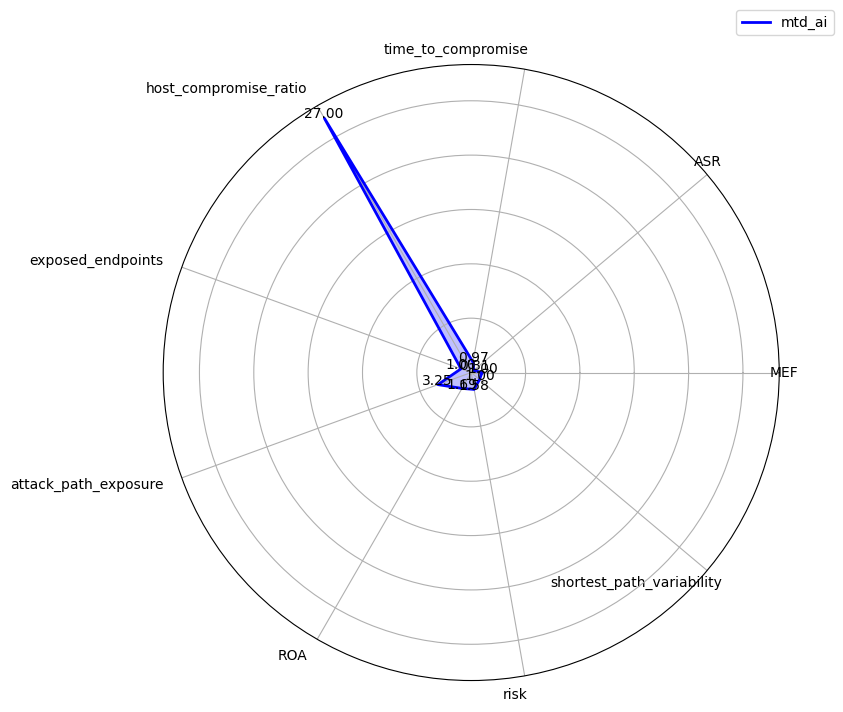

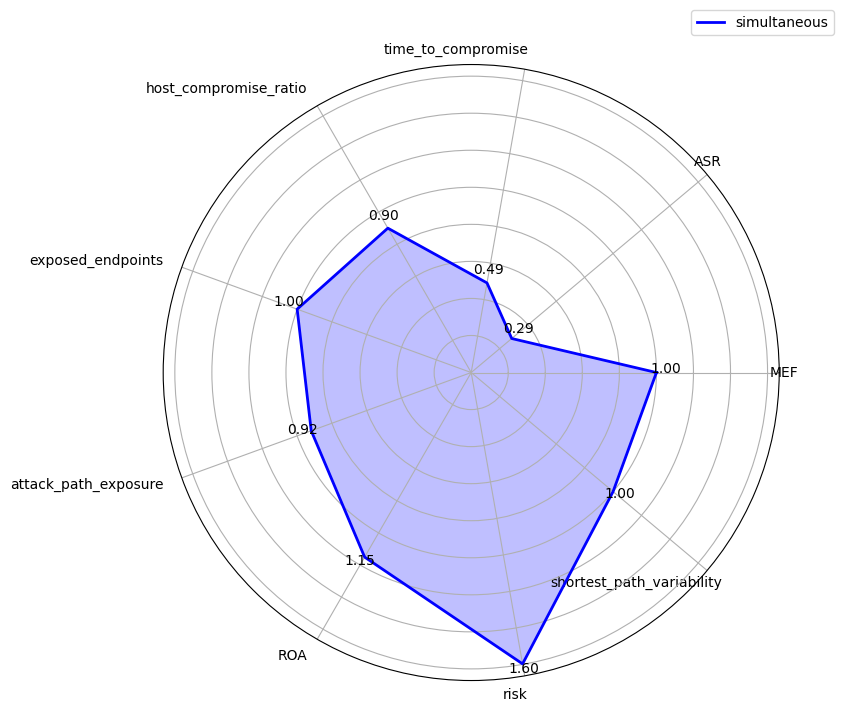

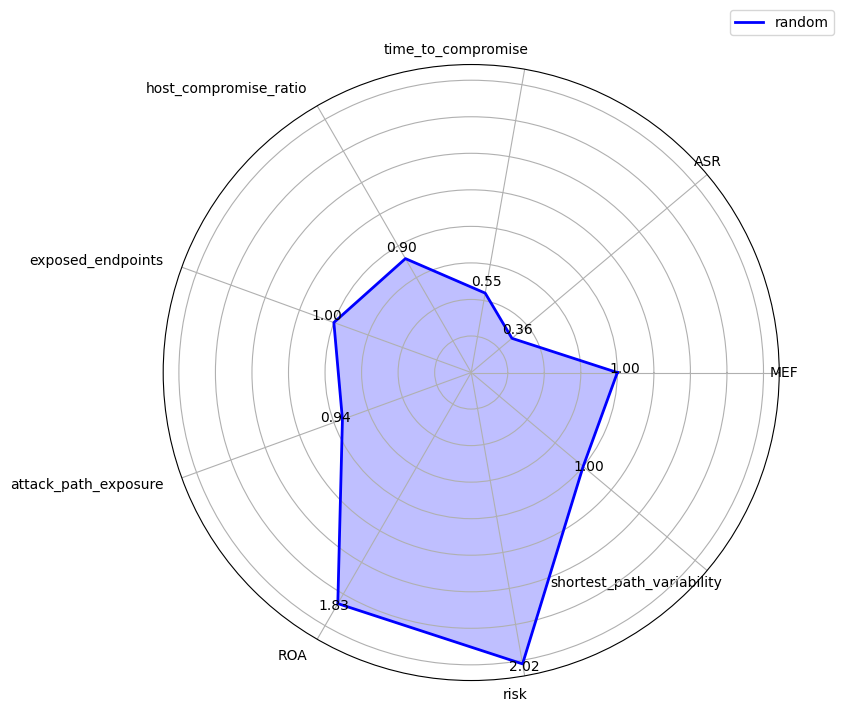

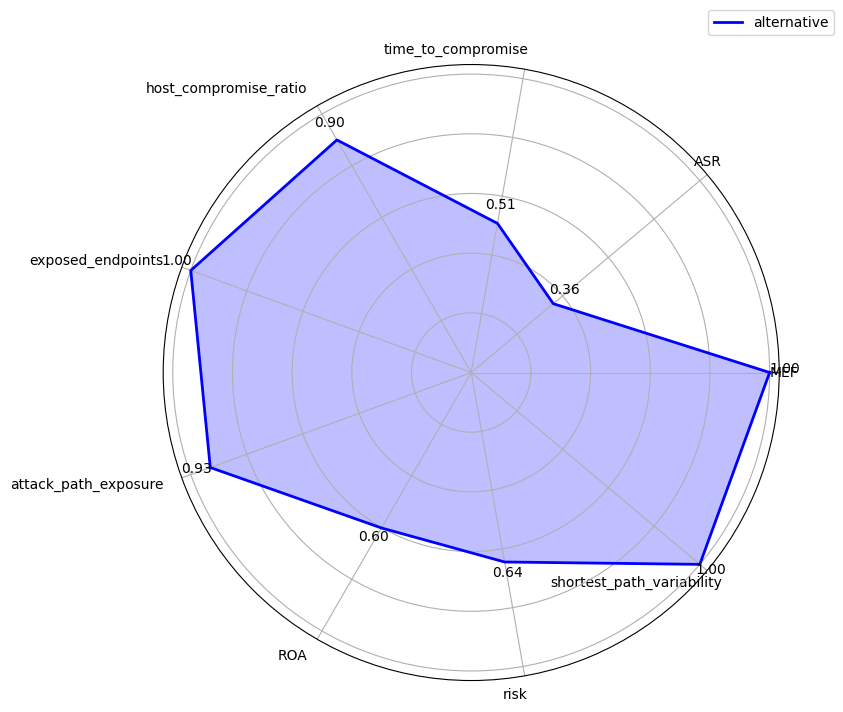

In [72]:
for scheme, data in results.items():
    radar.plot_single_radar(data, scheme, std_dev_values=None)
   